# ** F1 Race Predictor:Monaco Grand Prix Case Study**

In [7]:
#INSTALL NECESSARY PACKAGES AND LIBRARIES
!pip install fastf1
import fastf1          # F1 timing data access
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor   # ML model
from sklearn.metrics import mean_absolute_error          # Model evaluation
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer                 # Handling missing data

In [8]:
# Initialize cache with improved error handling
def initialize_cache():
    try:
        cache_dir = "f1_cache"         # Local directory to store cached data
        fastf1.Cache.enable_cache(cache_dir)       # To Enable caching
        print(f"Cache initialized at {cache_dir}")
    except Exception as e:
        print(f"Cache initialization warning: {str(e)[:100]}...")    # Truncate long errors

initialize_cache()           # Call the function to set up cache

Cache initialization warning: Cache directory does not exist! Please check for typos or create it first....


In [9]:
# Driver code mapping: - converts driver numbers to 3-letter codes
DRIVER_MAPPING = {
    '16': 'LEC', '81': 'PIA', '55': 'SAI', '4': 'NOR',
    '63': 'RUS', '1': 'VER', '44': 'HAM', '22': 'TSU',
    '23': 'ALB', '10': 'GAS', '14': 'ALO', '3': 'RIC',
    '77': 'BOT', '18': 'STR', '2': 'SAR', '24': 'ZHO',
    '31': 'OCO', '11': 'PER', '27': 'HUL', '20': 'MAG'
}

In [10]:
# Monaco-specific parameters that affect race outcomes
MONACO_FEATURES = {
    'safety_car_prob': 0.65,  # Historical probability, High probability due to tight circuit
    'pit_loss_time': 20.5,    # Time lost during pit stops (longer than other tracks)
    'wet_penalties': {        # How much slower drivers are in wet conditions
        'VER': 1.02, 'LEC': 1.03, 'SAI': 1.03, 'NOR': 1.04,
        'PIA': 1.04, 'HAM': 1.01, 'RUS': 1.02, 'ALO': 1.05,
        'STR': 1.06, 'GAS': 1.04, 'OCO': 1.04, 'TSU': 1.07,
        'ALB': 1.05, 'BOT': 1.06, 'ZHO': 1.06, 'RIC': 1.03,
        'HUL': 1.05, 'MAG': 1.06, 'PER': 1.03
    }
}

In [11]:
# Weather data simulation for Monaco
def get_monaco_weather():
    return {
        'temp': 22.5,       # Average May temperature in Monaco
        'humidity': 65,     # Typical humidity percentage
        'rain_prob': 0.25,  # 25% chance of rain(historical average)
        'wind_direction': 'NE'  # Northeast wind typical for Monaco
    }

In [12]:
# Load and process session data
def load_session_data(year, event, session):
    try:
      # Load session data from FastF1
        session = fastf1.get_session(year, event, session)
        session.load()
        # Extract relevant lap data columns
        laps = session.laps[["DriverNumber", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time", "Compound"]].copy()
        laps.dropna(inplace=True)

        # Map driver numbers to 3-letter codes
        laps['Driver'] = laps['DriverNumber'].map(DRIVER_MAPPING)
        laps = laps[laps['Driver'].notna()]

        # Time conversions(Convert timedelta objects to seconds for analysis)
        time_cols = ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]
        for col in time_cols:
            laps[f"{col}_s"] = laps[col].dt.total_seconds()

        return laps

    except Exception as e:
        print(f"Session loading error: {str(e)[:100]}...")
        # Fallback data if API fails - creates realistic sample data
        drivers = ['VER', 'LEC', 'SAI', 'NOR', 'PIA', 'RUS', 'HAM', 'ALB', 'ALO', 'STR']
        return pd.DataFrame({
            'Driver': drivers,
            'LapTime_s': np.linspace(78.0, 82.0, len(drivers)),       # Linear time spread
            'Sector1Time_s': np.linspace(26.0, 27.5, len(drivers)),
            'Sector2Time_s': np.linspace(26.5, 28.0, len(drivers)),
            'Sector3Time_s': np.linspace(25.5, 26.5, len(drivers))
        })

core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           


🏁 Predicted 2025 Monaco GP Results 🏁
Driver         Team  PredictedTime  Position
   OCO       Alpine      78.036804         1
   LEC      Ferrari      78.439890         2
   NOR      McLaren      78.481367         3
   VER     Red Bull      78.483145         4
   SAI      Ferrari      78.524057         5
   PIA      McLaren      78.525190         6
   HAM     Mercedes      78.577912         7
   RUS     Mercedes      78.590437         8
   HUL         Haas      78.756269         9
   MAG         Haas      79.310745        10
   TSU           RB      80.874744        11
   GAS       Alpine      81.028334        12
   BOT       Sauber      81.044575        13
   ALO Aston Martin      81.150322        14
   ALB     Williams      81.209470        15
   RIC           RB      81.230233        16
   STR Aston Martin      81.318921        17
   ZHO       Sauber      81.661489        18

🔍 Model MAE: 0.103 seconds

🏆 Predicted Podium 🏆
🥇 P1: OCO (Alpine) - 78.037s
🥇 P2: LEC (Ferrari) - 78.440

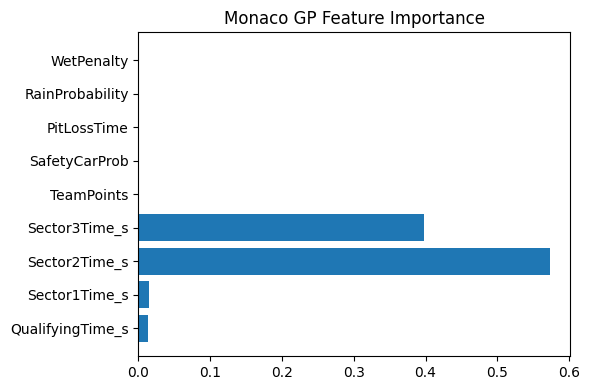

In [13]:
def predict_monaco_gp():
     # 1. DATA LOADING AND PREPARATION
    laps = load_session_data(2024, "Monaco", "R")     # Load historical race data
    weather = get_monaco_weather()                    # Get simulated weather

    # Create hypothetical qualifying data for prediction
    qualifying_2025 = pd.DataFrame({
        "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO",
                  "HAM", "STR", "GAS", "ALO", "HUL", "TSU", "RIC", "MAG", "BOT", "ZHO"],
        "QualifyingTime_s": [70.669, 69.954, 70.129, 70.500, 71.362, 71.213,
                            70.063, 70.942, 70.382, 72.563, 71.994, 70.924,
                            71.596, 71.200, 71.400, 72.100, 72.300, 72.500],
        "Team": ["Red Bull", "McLaren", "McLaren", "Mercedes", "Ferrari", "Williams",
                "Ferrari", "Alpine", "Mercedes", "Aston Martin", "Alpine", "Aston Martin",
                "Haas", "RB", "RB", "Haas", "Sauber", "Sauber"],
        "TeamPoints": [279, 246, 246, 147, 114, 28, 114, 50, 147, 77, 50, 77, 20, 25, 25, 20, 15, 15]
    })

    # 2. FEATURE ENGINEERING
    # Merge historical averages with current qualifying data
    historical_avg = laps.groupby("Driver")[["LapTime_s", "Sector1Time_s", "Sector2Time_s", "Sector3Time_s"]].mean().reset_index()
    data = qualifying_2025.merge(historical_avg, on="Driver", how="left")

    # Add Monaco-specific features
    data['SafetyCarProb'] = MONACO_FEATURES['safety_car_prob']      # High SC probability
    data['PitLossTime'] = MONACO_FEATURES['pit_loss_time']          # Time lost during pits
    data['RainProbability'] = weather['rain_prob']                   # Chance of rain

    # Apply wet weather penalties if rain probability > 30%
    if weather['rain_prob'] > 0.3:
        data['WetPenalty'] = data['Driver'].map(MONACO_FEATURES['wet_penalties'])
    else:
        data['WetPenalty'] = 1.0           # No penalty in dry conditions

    # Handle missing values with reasonable estimates
    data.fillna({
        'LapTime_s': data['QualifyingTime_s'] * 1.1,             # Race pace ~10% slower than quali
        'Sector1Time_s': data['QualifyingTime_s'] * 0.35,        # Sector time estimates
        'Sector2Time_s': data['QualifyingTime_s'] * 0.35,
        'Sector3Time_s': data['QualifyingTime_s'] * 0.3,
    }, inplace=True)

   # Select final features for model training
    features = [
        'QualifyingTime_s', 'Sector1Time_s', 'Sector2Time_s', 'Sector3Time_s',
        'TeamPoints', 'SafetyCarProb', 'PitLossTime', 'RainProbability', 'WetPenalty'
    ]
    X = data[features]
    y = data['LapTime_s']

    # 3. MODEL TRAINING
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Initialize and train Gradient Boosting model
    model = GradientBoostingRegressor(
        n_estimators=200,   # Number of boosting stages
        learning_rate=0.05, # Shrinkage factor
        max_depth=5,        # Maximum tree depth
        random_state=42     # Reproducibility
    )
    model.fit(X_train, y_train)   # Train model
    # 4. PREDICTIONS
    # Generate predictions with enhanced tie-breaking
    data['PredictedTime'] = model.predict(X)

     # Apply tie-breakers to handle similar performances:
    # 1. Small weight to qualifying time (better qualifiers get slight advantage)
    # 2. Team points (higher-ranked teams get minor benefit)
    # 3. Tiny random noise (final tie-breaker)
    data['PredictedTime'] += (data['QualifyingTime_s'] * 0.00001 +
                             data['TeamPoints'] * 0.000001 +
                             np.random.normal(0, 0.0001, len(data)))

    # 5.FINAL RESULTS PROCESSING
    # Sort drivers by predicted time
    results = data.sort_values('PredictedTime')[['Driver', 'Team', 'PredictedTime']]
    results['Position'] = range(1, len(results)+1)

    # Print results
    print("\n🏁 Predicted 2025 Monaco GP Results 🏁")
    print(results.to_string(index=False))

    # Model evaluation
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"\n🔍 Model MAE: {mae:.3f} seconds")

    # Podium announcement
    podium = results.head(3)
    print("\n🏆 Predicted Podium 🏆")
    for pos, (_, row) in enumerate(podium.iterrows(), 1):
        print(f"🥇 P{pos}: {row['Driver']} ({row['Team']}) - {row['PredictedTime']:.3f}s")

    # Feature importance
    plt.figure(figsize=(6,4))
    plt.barh(features, model.feature_importances_)
    plt.title("Monaco GP Feature Importance")
    plt.tight_layout()
    plt.show()

# Run prediction
predict_monaco_gp()